In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import scipy as sp
import findspark
import os
findspark.init(os.environ['SPARK_HOME'])
from pyspark.sql import *
from pyspark.sql.functions import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import folium
import json
import re
from IPython.core.display import display, HTML

%matplotlib inline

spark = SparkSession.builder.getOrCreate()

In [2]:
dataframe = pd.read_csv('../data/processed/clean_food_cities_arrond.csv')
dataframe = dataframe.drop(columns=['Unnamed: 0'])
dataframe.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,food_item_index,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,...,Poverty rate (tenants) (%),Share of activity revenue (%),Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%),Share of taxes (%),City name,Department,Region,custom_arrondissement_code
0,359180,14.0,19.0,4,150 g,1243.0,24.0,17.0,19.0,1.3,...,29.609475,65.9,31.2,11.1,7.1,-15.3,Belley,01,84,01001
1,359153,15.0,20.0,4,NaN,1402.0,30.0,19.0,15.0,1.3,...,29.609475,65.9,31.2,11.1,7.1,-15.3,Belley,01,84,01001
2,359177,15.0,20.0,4,NaN,1435.0,31.0,21.0,15.0,1.0,...,29.609475,65.9,31.2,11.1,7.1,-15.3,Belley,01,84,01001
3,359157,14.0,19.0,4,NaN,1238.0,24.0,18.0,19.0,1.0,...,29.609475,65.9,31.2,11.1,7.1,-15.3,Belley,01,84,01001
4,359155,15.0,20.0,4,NaN,1435.0,31.0,21.0,15.0,1.0,...,29.609475,65.9,31.2,11.1,7.1,-15.3,Belley,01,84,01001


# 1. Distribution of the products per nutrition grade

* Nutrition grade has integer values between 1 and 5, 1 indicating healthy food items and 5 describing unhealthy items.

* Nutrition score (UK or Fr.) has values between -15 and 40. -15 indicates a healthy food item, 40 indicates an unhealthy food item. 

The correspondence between the two of them for solid foods is:

* Nutrition grade = 1 : nutrition score $\in [-15, : -1]$
* Nutrition grade = 2 : nutrution score $\in [0, 2]$
* Nutrition grade = 3 : nutrition score $\in [3, 10]$
* Nutrition grade = 4 : nutrition score $\in [11, 18]$
* Nutrition grade = 5 : nutrition score $\in [19, 40]$

The correspondence between the two of them for beverages is:

* Nutrition grade = 1 : Water
* Nutrition grade = 2 : nutrution score $\in [-15, 1]$
* Nutrition grade = 3 : nutrition score $\in [2, 5]$
* Nutrition grade = 4 : nutrition score $\in [6, 9]$
* Nutrition grade = 5 : nutrition score $\in [10, 40]$

https://fr.openfoodfacts.org/nutriscore

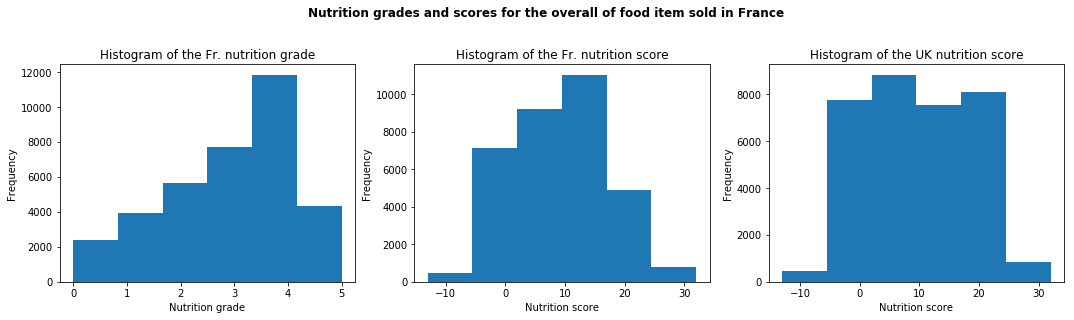

In [169]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
f.suptitle("Nutrition grades and scores for the overall of food item sold in France", 
           y=1.08, fontweight="bold")
dataframe['nutrition_grade_numeric'].plot.hist(bins=6, ax=ax1)
ax1.set_title("Histogram of the Fr. nutrition grade")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Nutrition grade")

dataframe['nutrition-score-fr_100g'].plot.hist(bins=6, ax=ax2)
ax2.set_title("Histogram of the Fr. nutrition score")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Nutrition score")

dataframe['nutrition-score-uk_100g'].plot.hist(bins=6, ax=ax3)
ax3.set_title("Histogram of the UK nutrition score")
ax3.set_ylabel("Frequency")
ax3.set_xlabel("Nutrition score")
plt.show()

When we look at the nutrition grade histogram, we see that most of the products are labeled with a `3` or below, which indicates that healthy products are rare in comparison. 

When looking at the nutrition score histograms, the lack of healthy products is reinforced, however there are also a lot less **very** unhealthy products.

Since these 3 columns in our dataframe describe the same thing, we need to choose one. Intuitively, we would choose Nutrition grade because it already gives us a judgement on the quality of the food independently on if the item is solid food or beverage. 

We will however introduce two more nutrition metrics, and after that we will compute PCA on our dataframe to select only the relevant columns (i.e. columns that don't have the **exact same information**, columns that are not **redundant**). 

Reminder: `0` is equivalent to no data.

# 2. Implementation of custom nutrition scores

We introduce two more nutrition scores: calory density (the calories per serving size) and calory deviation.

Calory deviation is computed according to the nutritional standards that the calories that we consume in a day should be composed of $21 \%$ from protein, $53 \%$ from carbohydrates and $26 \%$ from fat. We then compute a deviation from this tandard for each product. 

* In the first case (calory density), the metric describes how largely a product is packed with calories. Since obesity is linked with the density in calories of the ingested food items, this metric might be useful.

* In the second case (calory deviation) we aim at observing whether the products follow a healthy calory distribution. This metric would show us if a certain region has bad nutrition habits with respect to the ratios of nutriments they should eat. 

In [3]:
cals = dataframe[['energy_100g','serving_size']]
cals = cals.dropna()

cals = cals.drop(cals[cals['serving_size'].str.contains("mg")].index)
cals = cals.drop(cals[cals['serving_size'].str.contains('oeuf')].index)
cals = cals.drop(cals[cals['serving_size'].str.contains('Deux tranches g')].index)

cal = cals['serving_size'].str.replace('.*?(?P<number>[0-9.,]+)\s*(G|g|f|ml|mL).*', '\\g<number>')
cal = cal.str.replace('.*?([0-9.,]+) *(cl|cL).*', '\\g<1>0')
cal = cal.str.replace('.*?([0-9.,]+) *(Kg|L|l).*', '\\g<1>000')
cal = cal.str.replace('[^0-9]+', '')
cal = cal.replace('', np.nan)
cal = cal.dropna()
cal = cal.str.replace(",", ".").astype('float')
cals.serving_size = cal
dataframe.loc[:,'serving_size'] = cal

cal_density = cals.serving_size*cals.energy_100g/100

**Note**

Proteins should make 21% of total cals (protein has 4 cals/g)

Carbohydrates should make 53% of total cals (carbohydrates have 4 cals/g)

Fat should make 26% of total cals (fats have 9 cals/g)

In [4]:
cal_density.describe()

count     20293.000000
mean       1060.492669
std        3444.981986
min           0.000000
25%         360.500000
50%         512.700000
75%         889.200000
max      113662.120000
dtype: float64

In [5]:
# energy has to be divided by 4.184 to convert from Joules to kilocalories
cal_deviation = ((dataframe.fat_100g*9/(dataframe.energy_100g/4.184) - 0.26) + 
                (dataframe.carbohydrates_100g*4/(dataframe.energy_100g/4.184) - 0.53) +
                (dataframe.proteins_100g*4/(dataframe.energy_100g/4.184) - 0.21))/3
cal_deviation.replace(np.infty, np.nan, inplace=True)
cal_deviation.dropna(inplace=True)
cal_deviation.describe()

count    35169.000000
mean         0.020618
std          1.550737
min         -0.333333
25%         -0.008037
50%         -0.002448
75%          0.000834
max        139.133333
dtype: float64

In [6]:
dataframe.loc[:,'cal_density'] = cal_density
dataframe.loc[:,'cal_deviation'] = cal_deviation

In [7]:
dataframe.head()

,food_item_index,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,...,Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%),Share of taxes (%),City name,Department,Region,custom_arrondissement_code,cal_density,cal_deviation
0,359180,14.0,19.0,4,150.0,1243.0,24.0,17.0,19.0,1.3,...,31.2,11.1,7.1,-15.3,Belley,01,84,01001,1864.5,0.000130
1,359153,15.0,20.0,4,NaN,1402.0,30.0,19.0,15.0,1.3,...,31.2,11.1,7.1,-15.3,Belley,01,84,01001,NaN,0.000113
2,359177,15.0,20.0,4,NaN,1435.0,31.0,21.0,15.0,1.0,...,31.2,11.1,7.1,-15.3,Belley,01,84,01001,NaN,0.000026
3,359157,14.0,19.0,4,NaN,1238.0,24.0,18.0,19.0,1.0,...,31.2,11.1,7.1,-15.3,Belley,01,84,01001,NaN,0.000125
4,359155,15.0,20.0,4,NaN,1435.0,31.0,21.0,15.0,1.0,...,31.2,11.1,7.1,-15.3,Belley,01,84,01001,NaN,0.000026


# 3.  Decide which columns to keep

In [8]:
numeric_cols = ['food_item_index', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'Median revenue euros',
       'Total poverty rate (%)', 'Poverty rate (-30) (%)',
       'Poverty rate (30-39) (%)', 'Poverty rate (40-49) (%)',
       'Poverty rate (50-59) (%)', 'Poverty rate (60-74) (%)',
       'Poverty rate (75+) (%)', 'Poverty rate (house owners) (%)',
       'Poverty rate (tenants) (%)', 'Share of activity revenue (%)',
       'Share of retreat pension revenue (%)',
       'Share of heritage revenue and other (%)',
       'Share of social benefits revenue (%)', 'Share of taxes (%)',
       'cal_density', 'cal_deviation']

In [9]:
for column in numeric_cols:
    nonna = len(dataframe[dataframe[column].apply(lambda x: not np.isnan(x))])*100/len(dataframe)
    non_na = str(nonna) + '%'
    print('{:<45s}{:<30s}{:<55s}'.format(column, 'Number of non-na:', non_na))

food_item_index                              Number of non-na:             100.0%                                                 
nutrition-score-fr_100g                      Number of non-na:             93.39499122489345%                                     
nutrition-score-uk_100g                      Number of non-na:             93.39499122489345%                                     
nutrition_grade_numeric                      Number of non-na:             100.0%                                                 
serving_size                                 Number of non-na:             56.53118645012118%                                     
energy_100g                                  Number of non-na:             99.18377580299189%                                     
fat_100g                                     Number of non-na:             99.48742234727136%                                     
saturated-fat_100g                           Number of non-na:             97.76304

We decided to drop all columns that have less than $50 \%$ of non-NaN values.

In [11]:
dataframe = dataframe[['food_item_index', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
                       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
                       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
                       'sugars_100g', 'fiber_100g', 'cal_density', 'cal_deviation', 
                       'Median revenue euros','City name', 'Department', 
                       'Region', 'custom_arrondissement_code']]

In [181]:
def normalize(tx, mean=None, std=None):
    """Normalize every feature of the input

    Arguments:
    ---------
    tx: numpy.ndarray
        Input to normalize
    mean: numpy.ndarray
        Mean around which we center each feature
    std: numpy.ndarray
        Factor by which we want to reduce the current standard deviation for each feature

    Returns:
        mean: numpy.ndarray
            Mean of each feature
        std: numpy.ndarray
            Standard deviation of each feature
        normalized_input: numpy.ndarray
            Normalized matrix
    """
    if mean is None:
        mean = np.mean(tx, axis=0)
    centered = tx - mean
    if std is None:
        std = np.std(centered, axis=0)
    std[std == 0] = 1
    return mean, std, centered / std

# 4. Aggregation

Aggregation by geographic location (City, arrondissement, department or region) using 2 metrics: mean and median

**1. Mean**

In [17]:
dataframe_city = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'Department']).dropna().groupby('City name').mean()
dataframe_arr = dataframe.drop(columns=['Region', 'City name', 'Department']).dropna().groupby('custom_arrondissement_code').mean()
dataframe_dep = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'City name']).dropna().groupby('Department').mean()
dataframe_reg = dataframe.drop(columns=['Department', 'custom_arrondissement_code', 'City name']).dropna().groupby('Region').mean()

**2. Median**

In [18]:
dataframe_city_med = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'Department']).dropna().groupby('City name').median()
dataframe_arr_med = dataframe.drop(columns=['Region', 'City name', 'Department']).dropna().groupby('custom_arrondissement_code').median()
dataframe_dep_med = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'City name']).dropna().groupby('Department').median()
dataframe_reg_med = dataframe.drop(columns=['Department', 'custom_arrondissement_code', 'City name']).dropna().groupby('Region').median()

# 5. Clustering

In [54]:
nutri_cols = ['nutrition-score-fr_100g', 'nutrition-score-uk_100g',
              'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
              'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g','sugars_100g', 
              'fiber_100g', 'cal_density', 'cal_deviation']

**1. Cities**

In [46]:
def plot_scatter(df):
    fig, axs = plt.subplots(4, 4, figsize=(25, 25))
    fig.suptitle("Scatter plots of the relationships between each nutrition attribute and the Median Revenue", 
                fontweight="bold")
    i = 0;
    j = 0;
    count = 1;
    for col in nutri_cols:
        df.plot.scatter(x='Median revenue euros', y=col, ax=axs[i, j])
        axs[i, j].set_title(col)
        if count%4 == 0:
            i = i + 1;
        j = (j + 1)%4;
        count = count+1
    fig.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


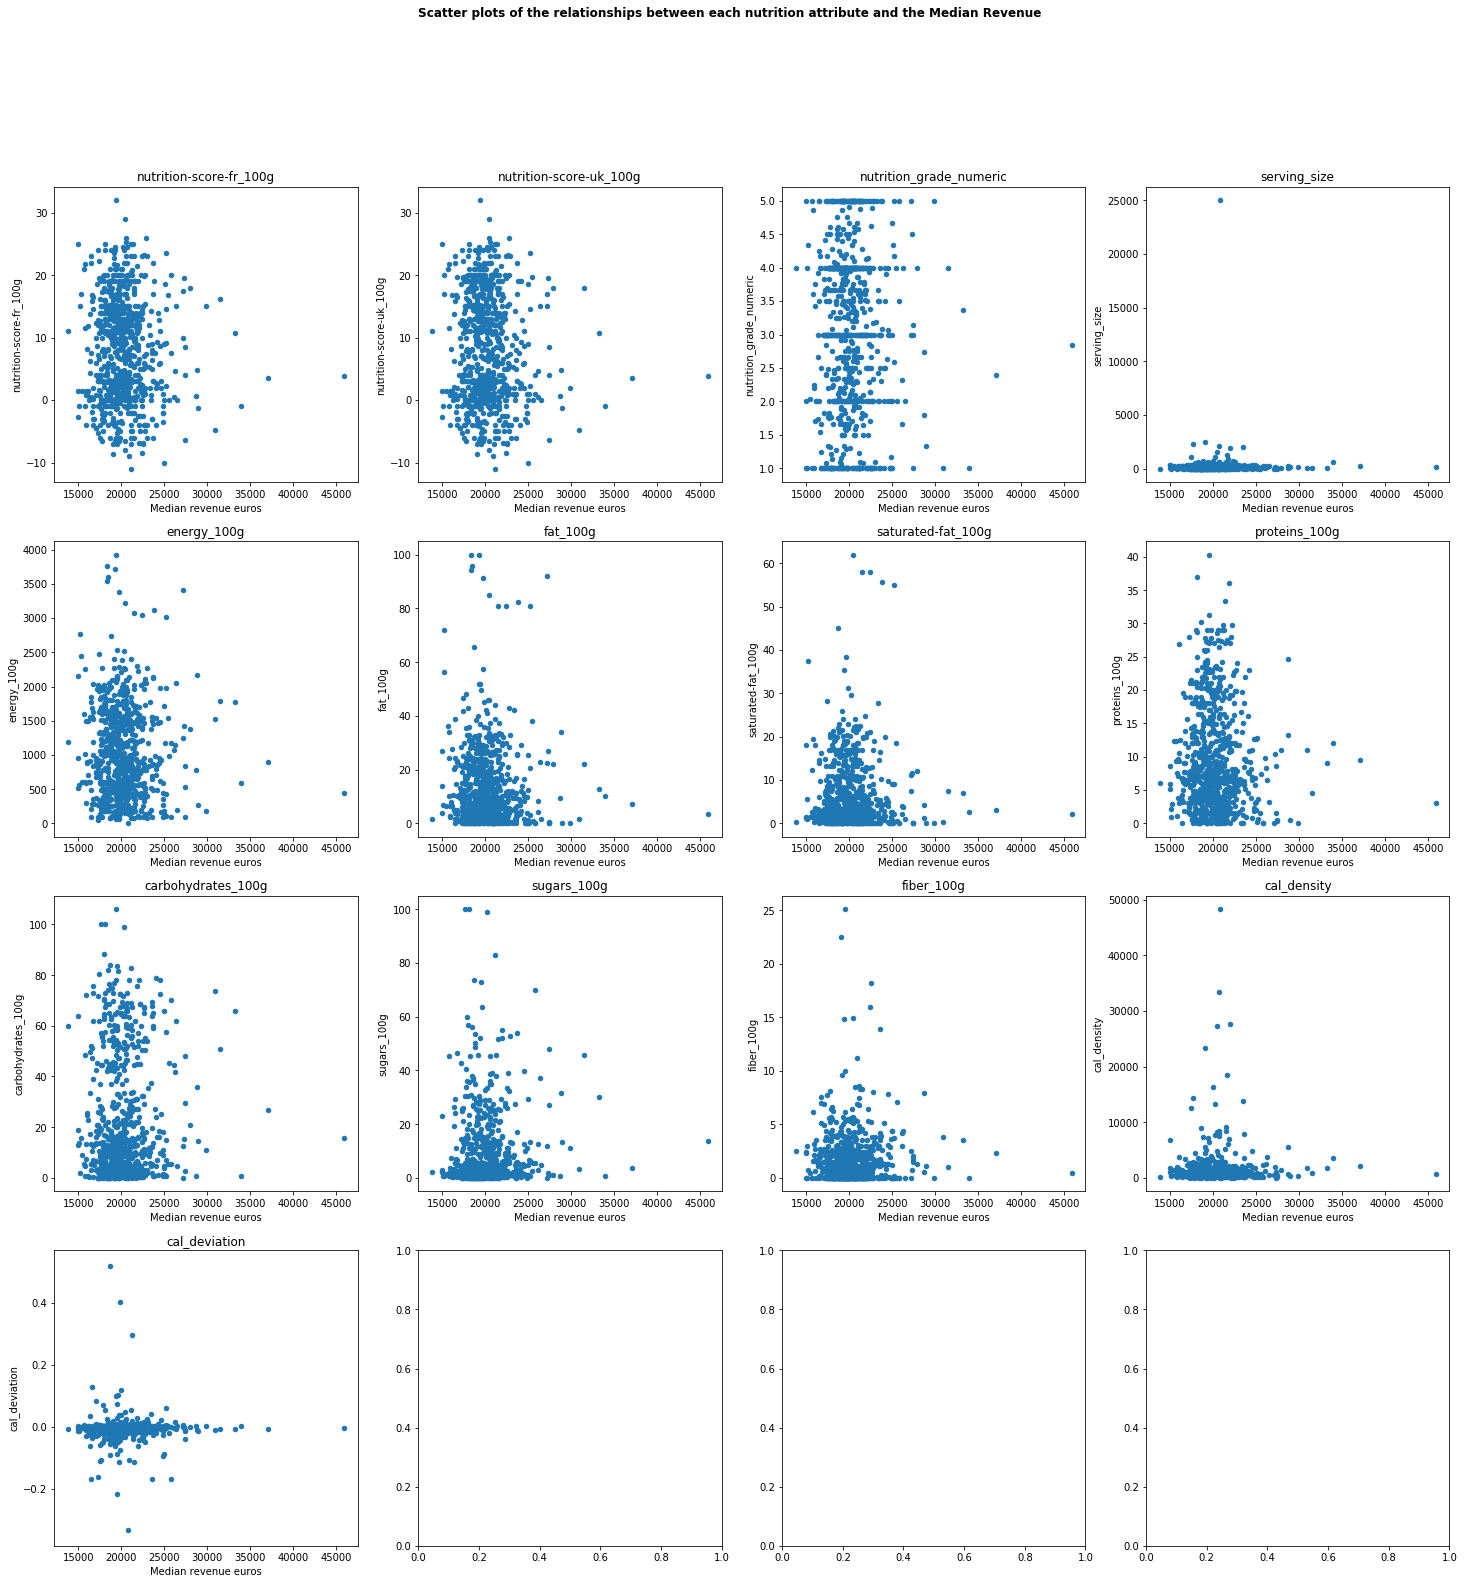

In [55]:
plot_scatter(dataframe_city)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


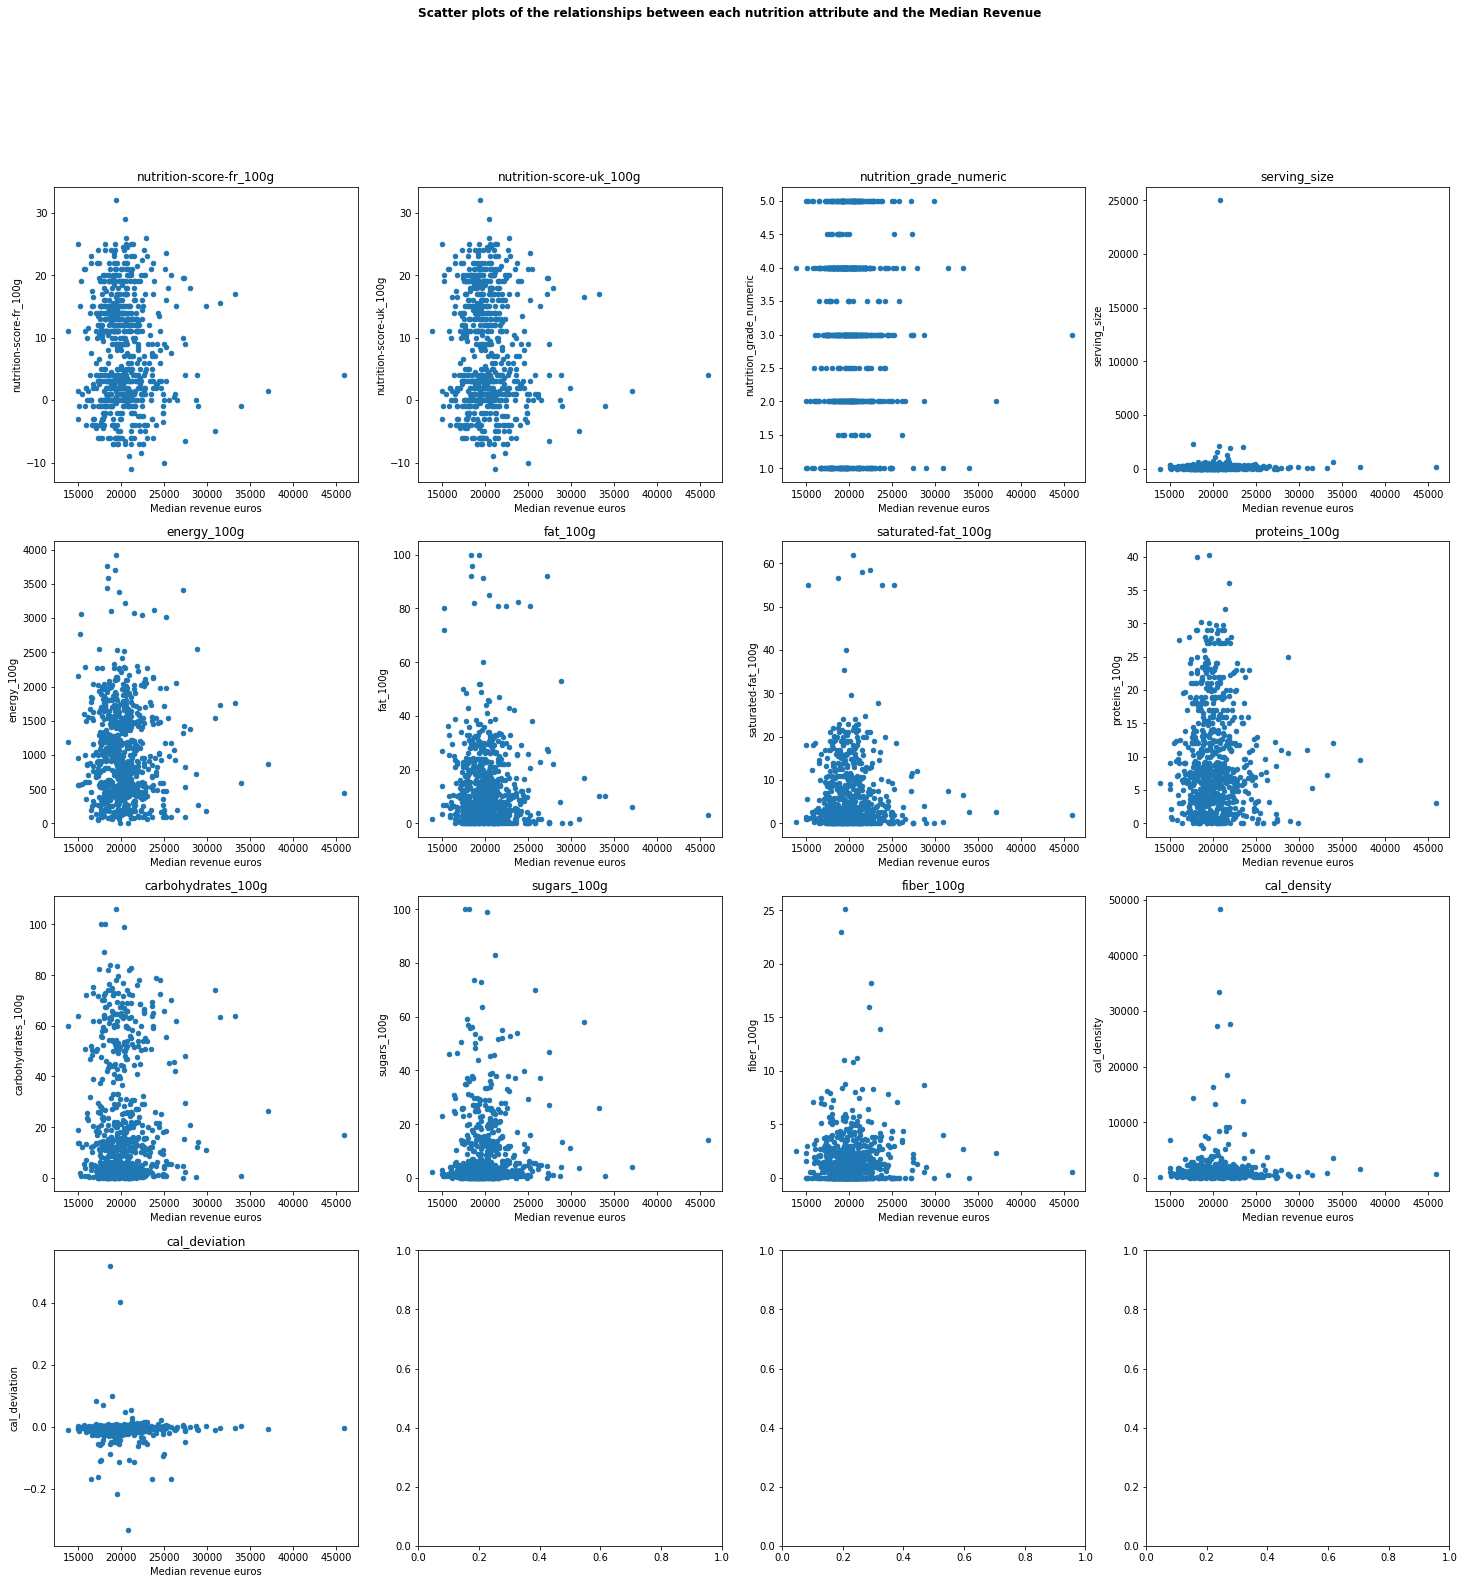

In [56]:
plot_scatter(dataframe_city_med)

**2. Arrondissements**

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


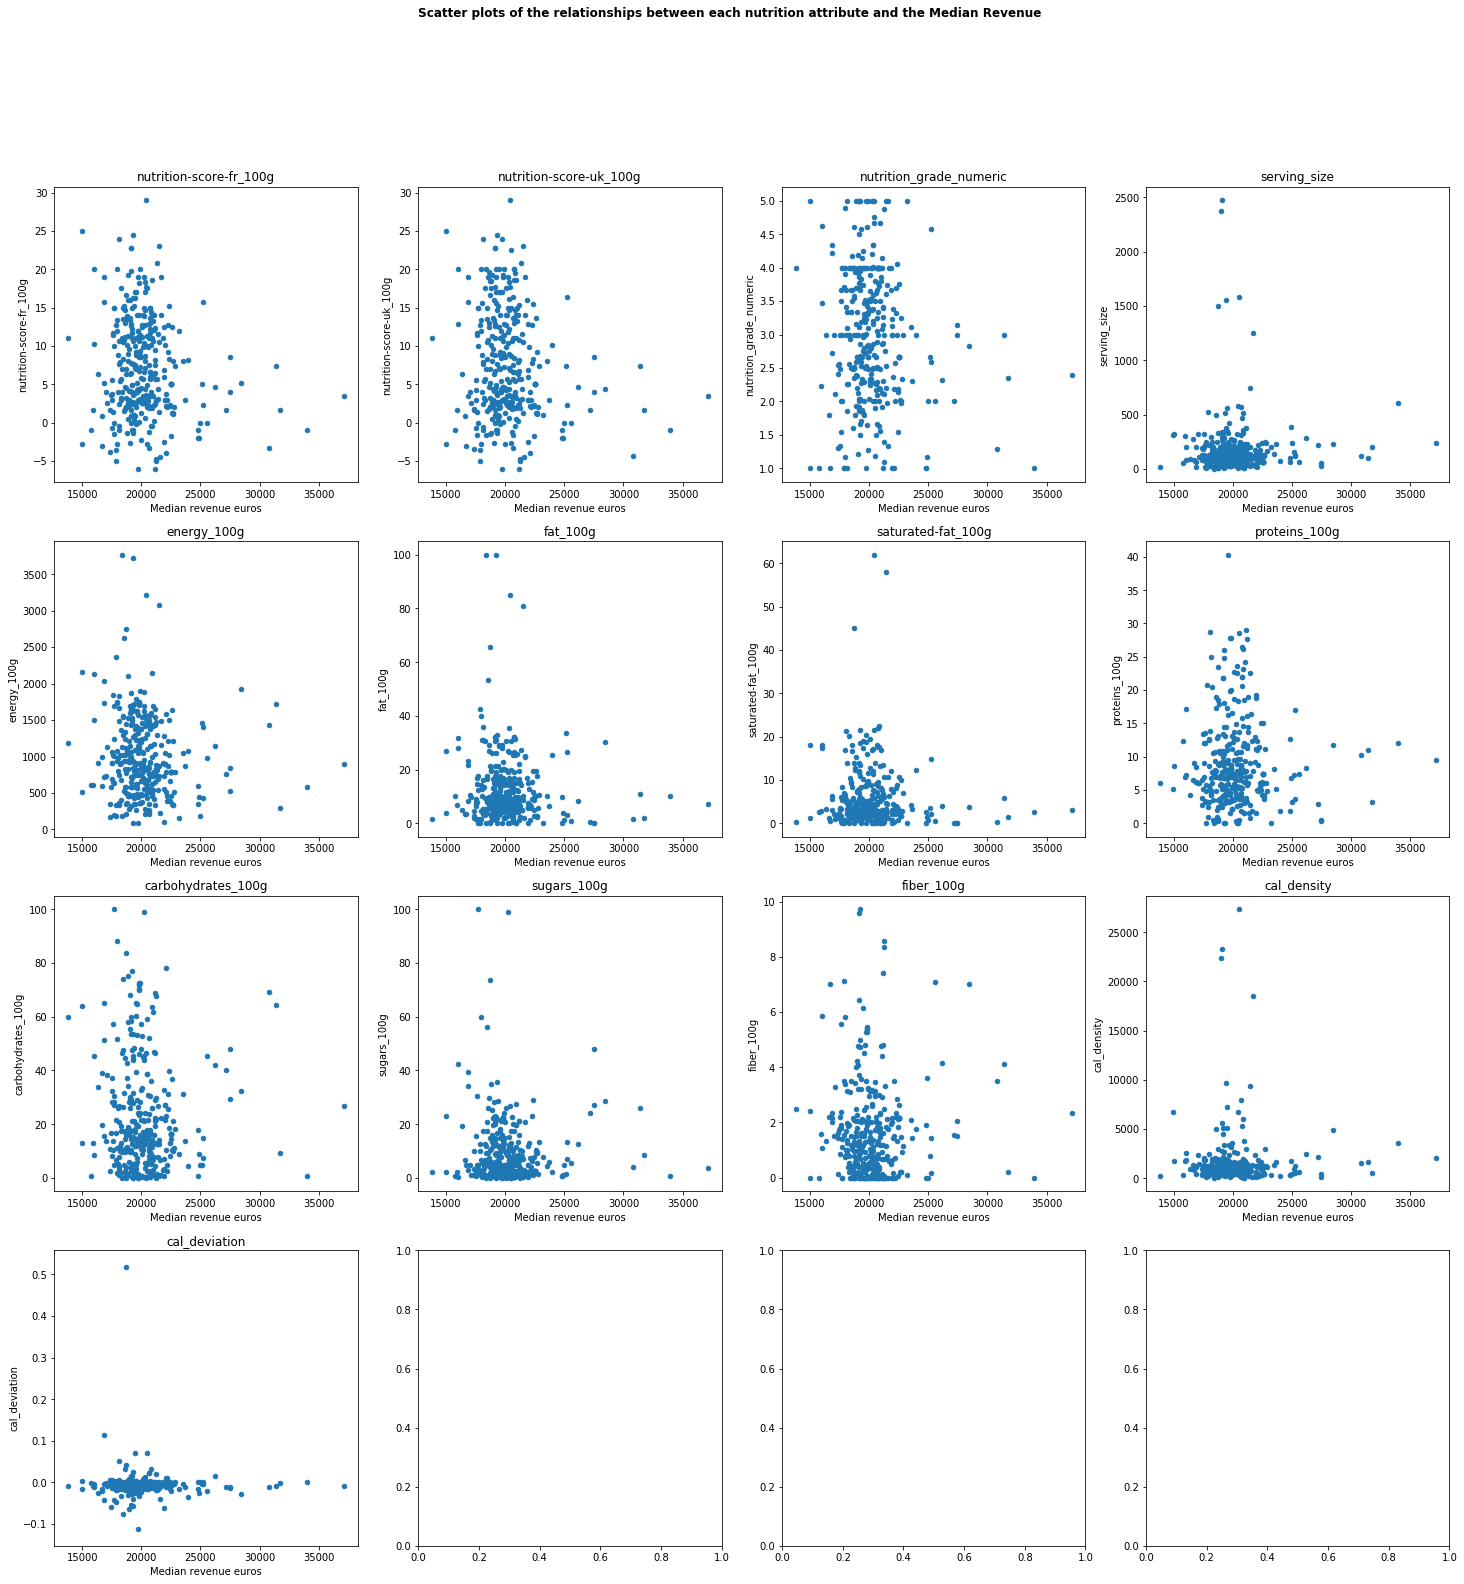

In [57]:
plot_scatter(dataframe_arr)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


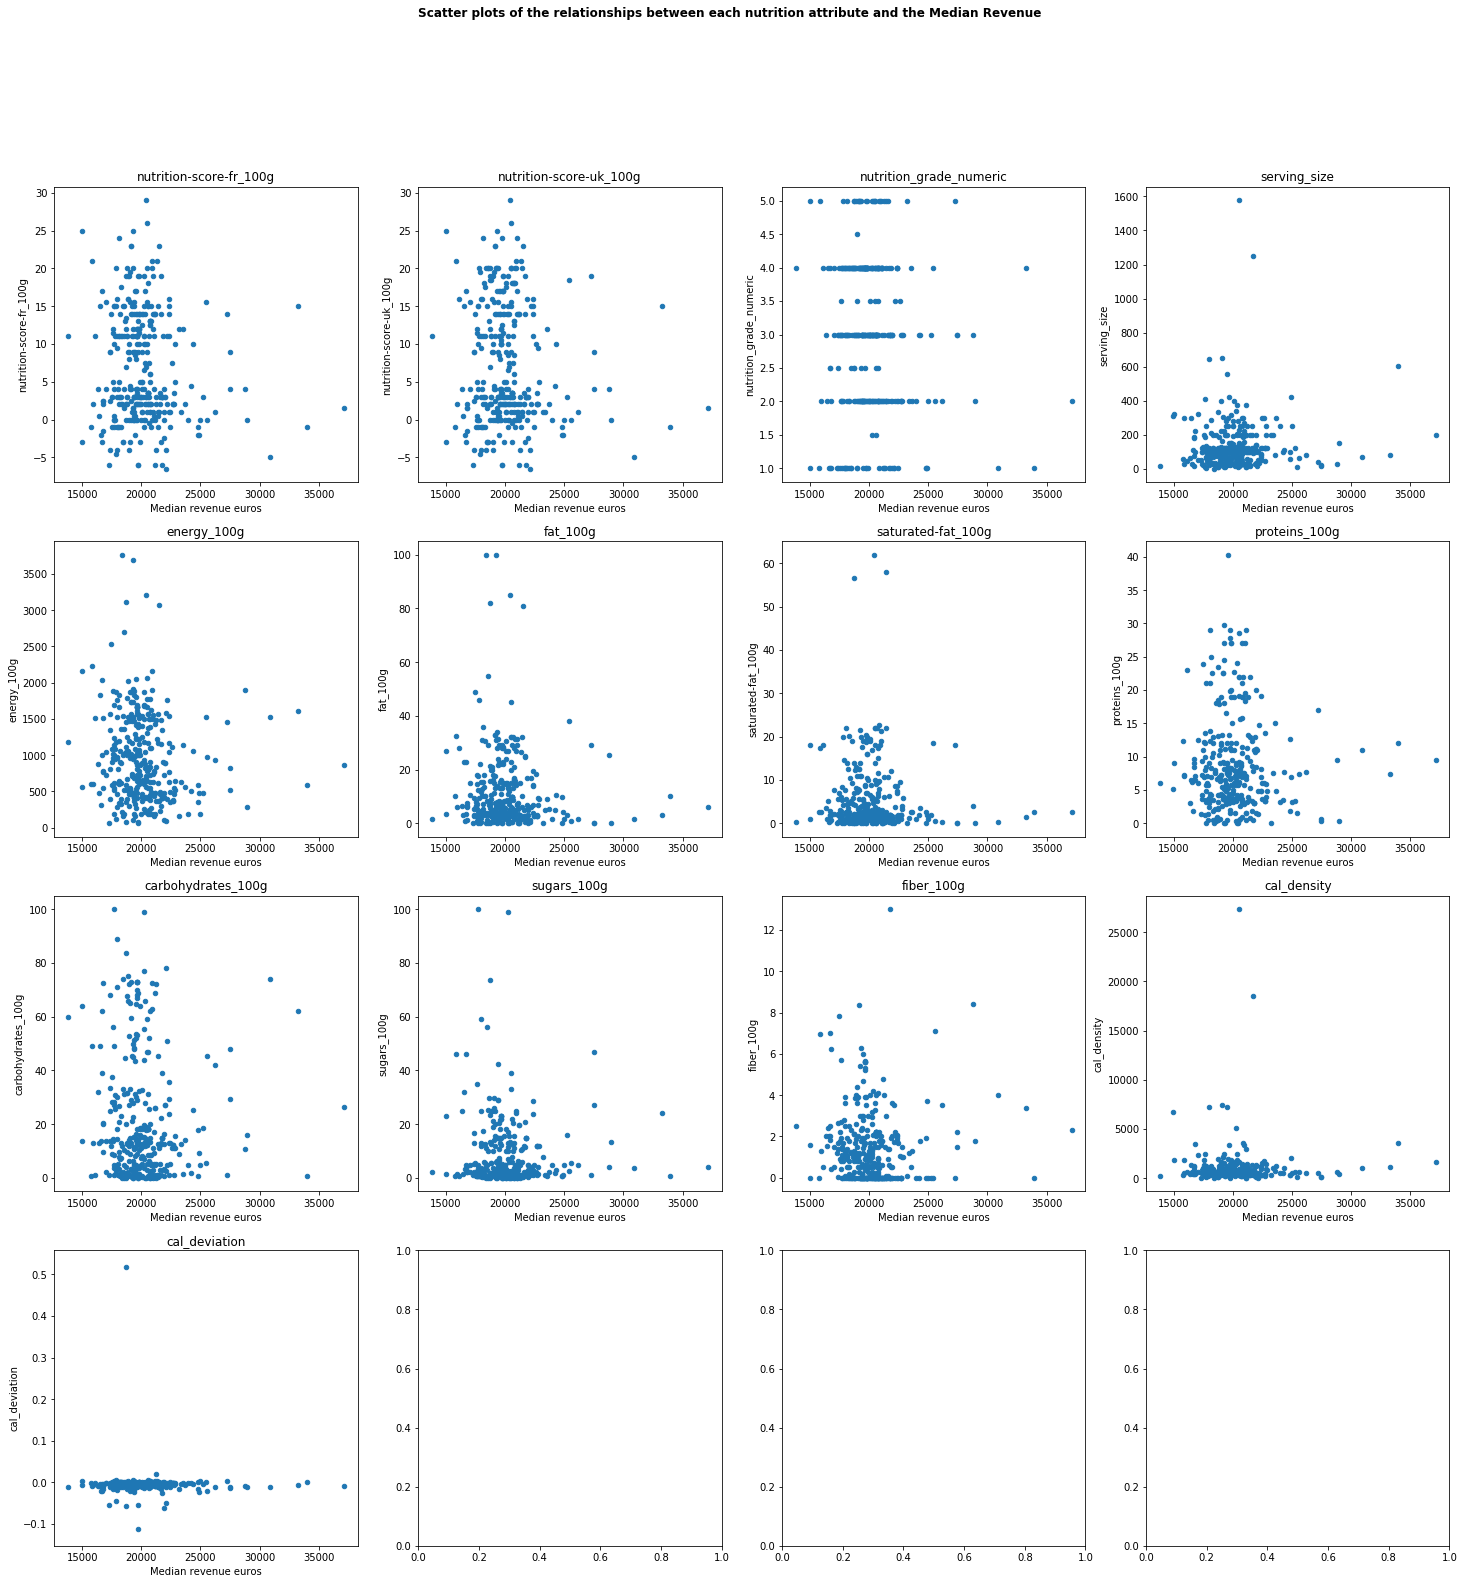

In [58]:
plot_scatter(dataframe_arr_med)

**3. Departments**

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


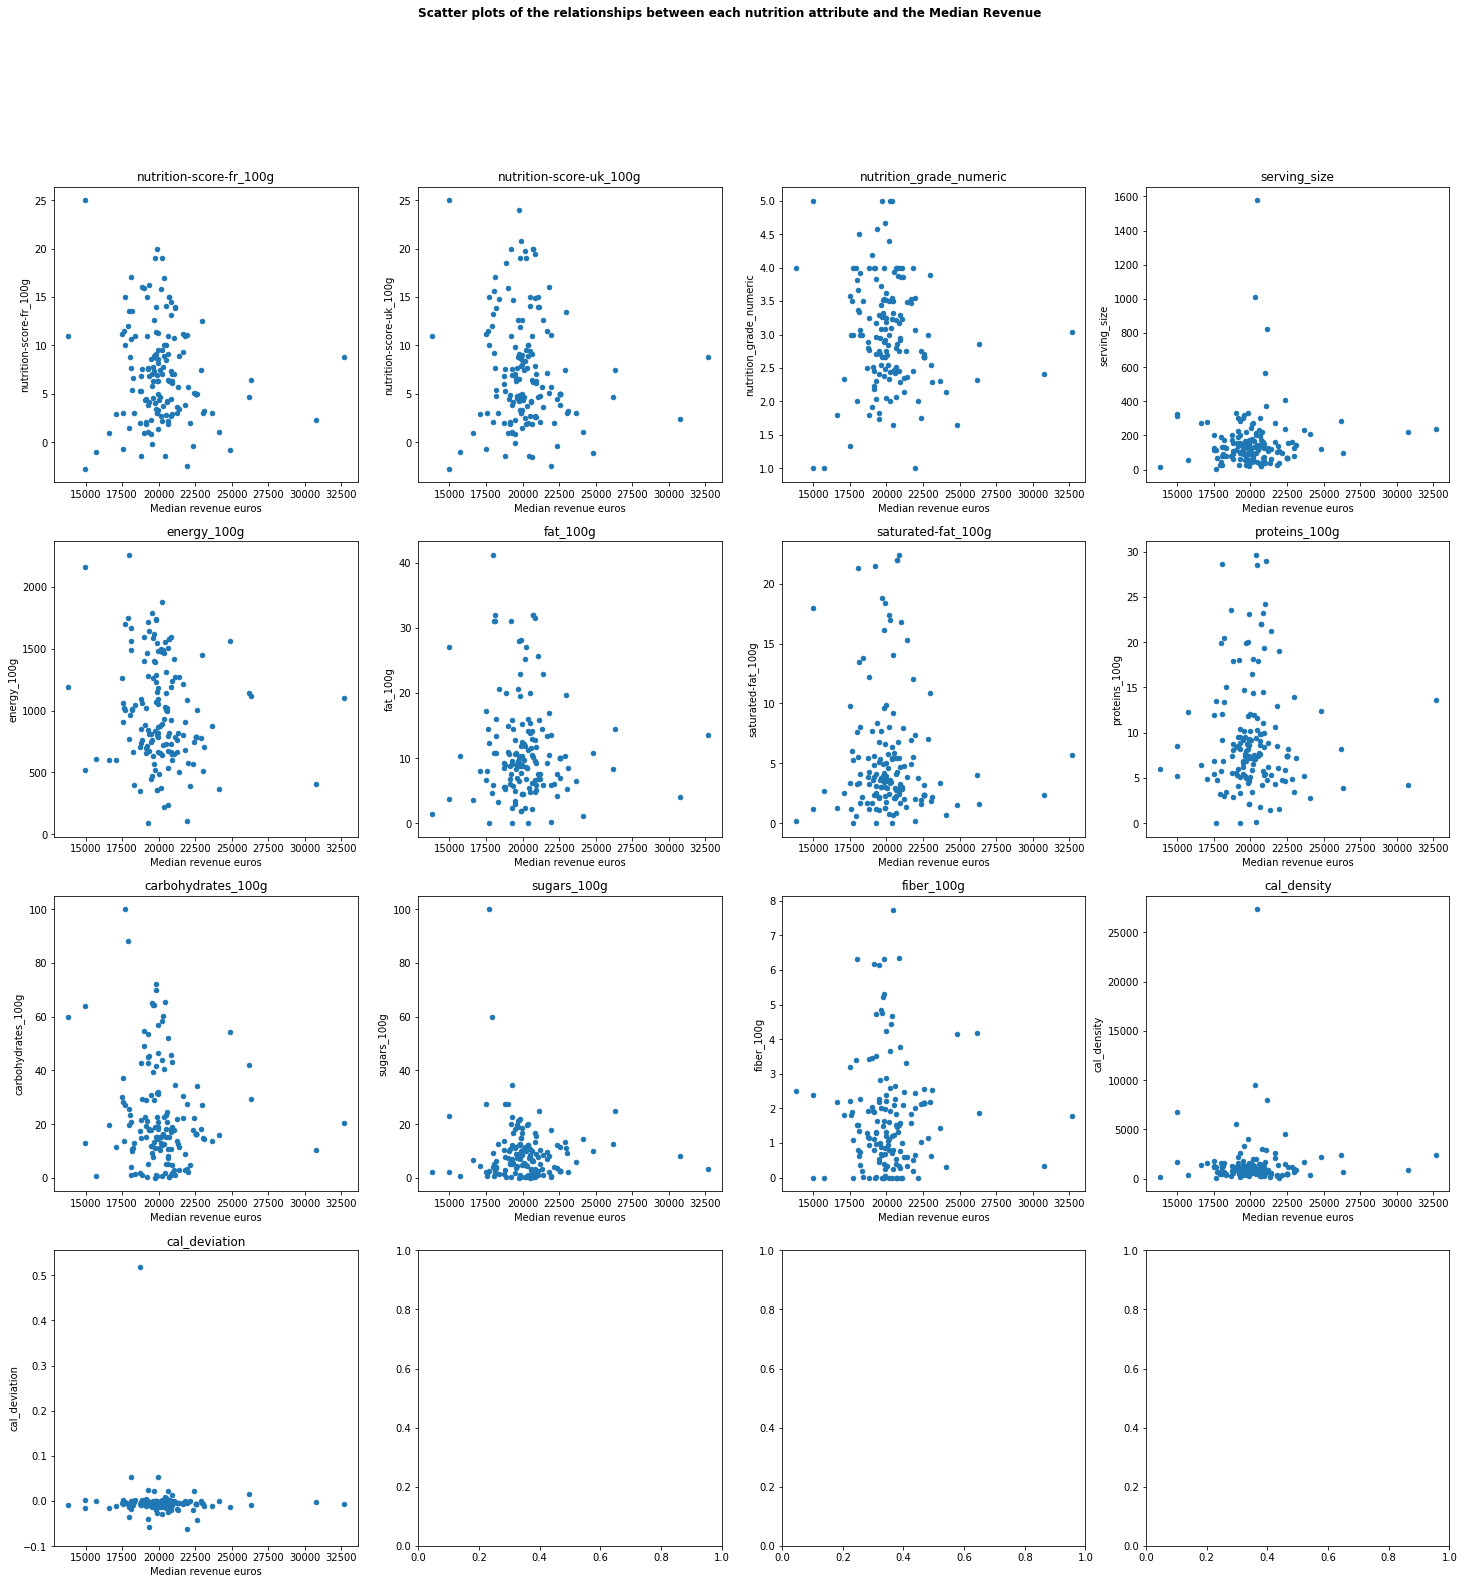

In [59]:
plot_scatter(dataframe_dep)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


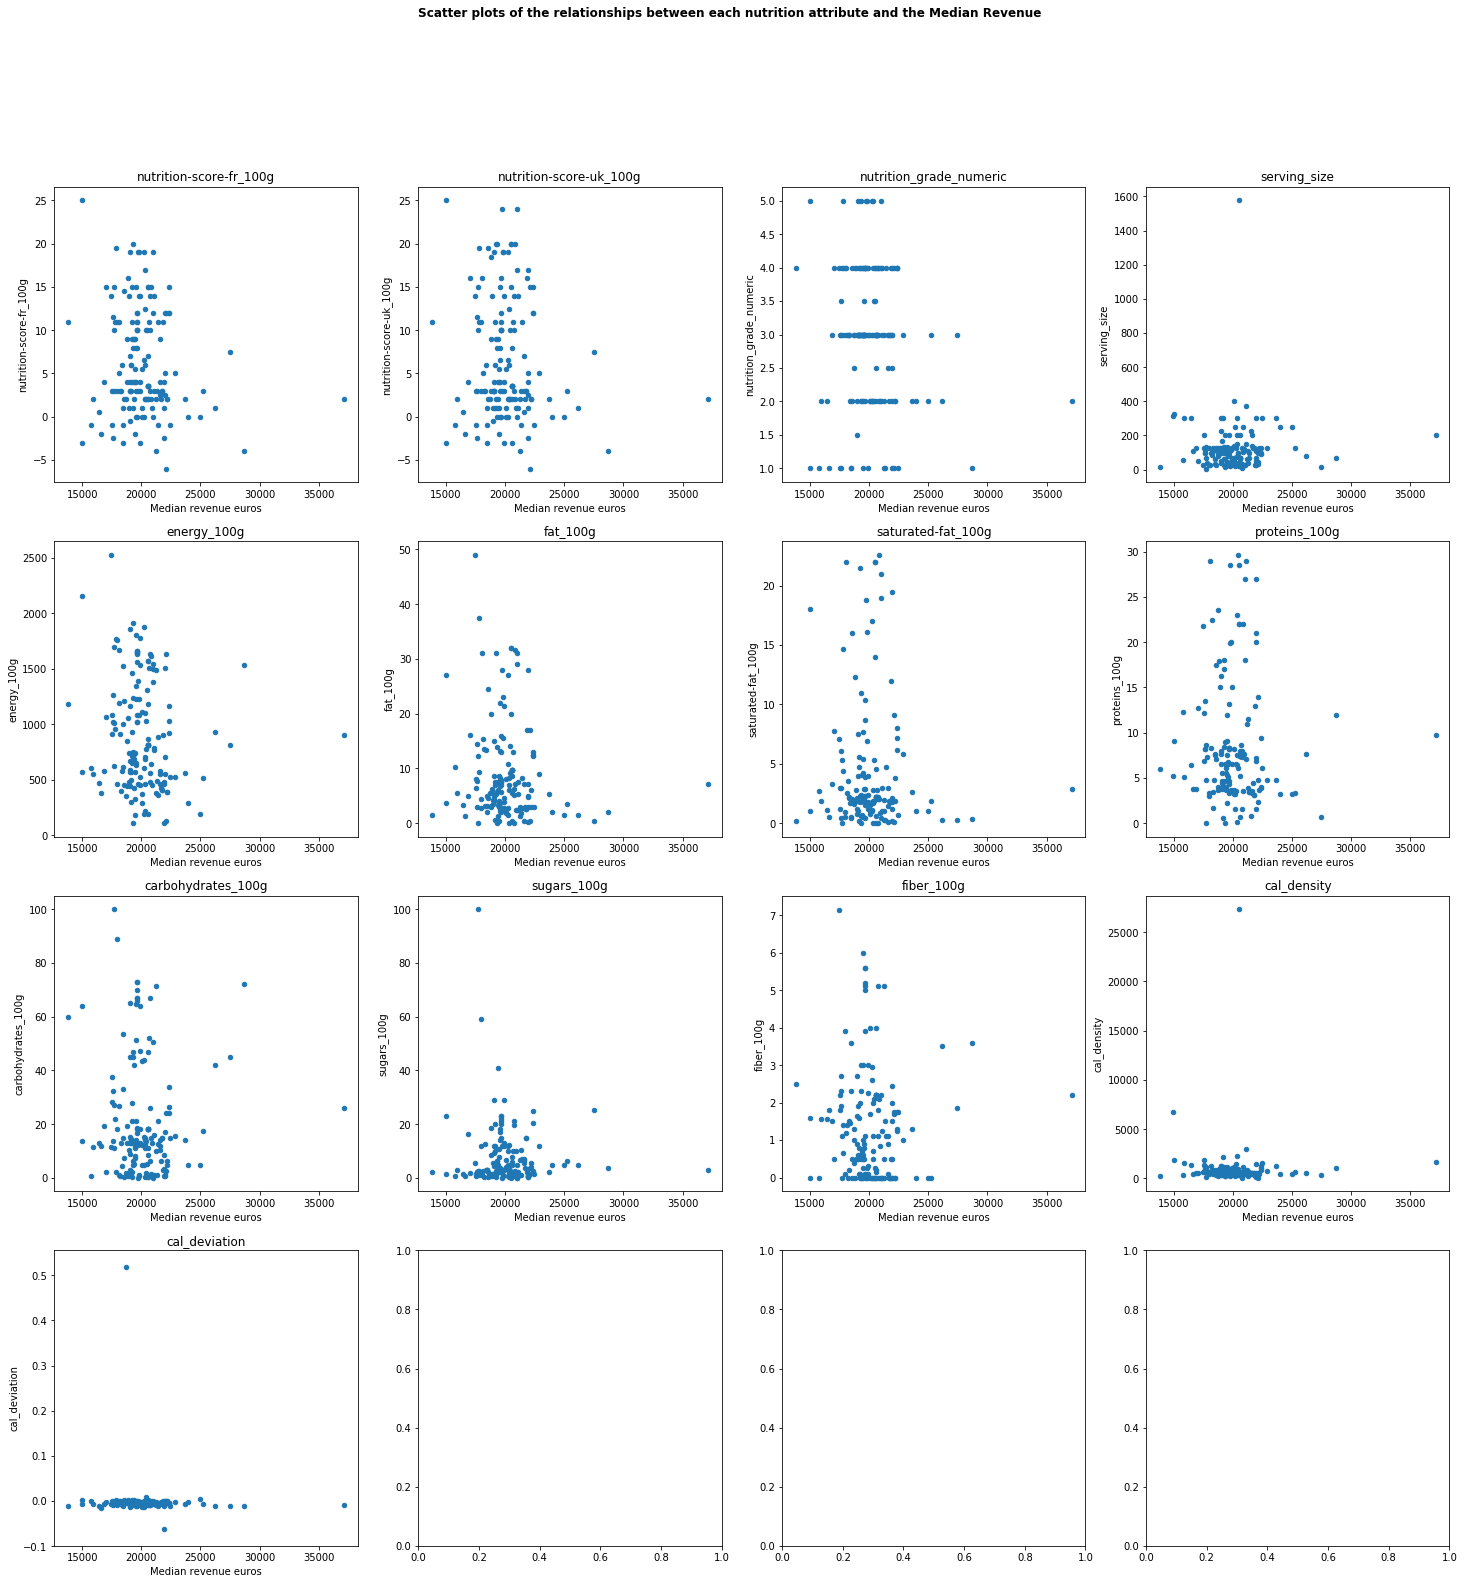

In [60]:
plot_scatter(dataframe_dep_med)

**4. Regions**

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


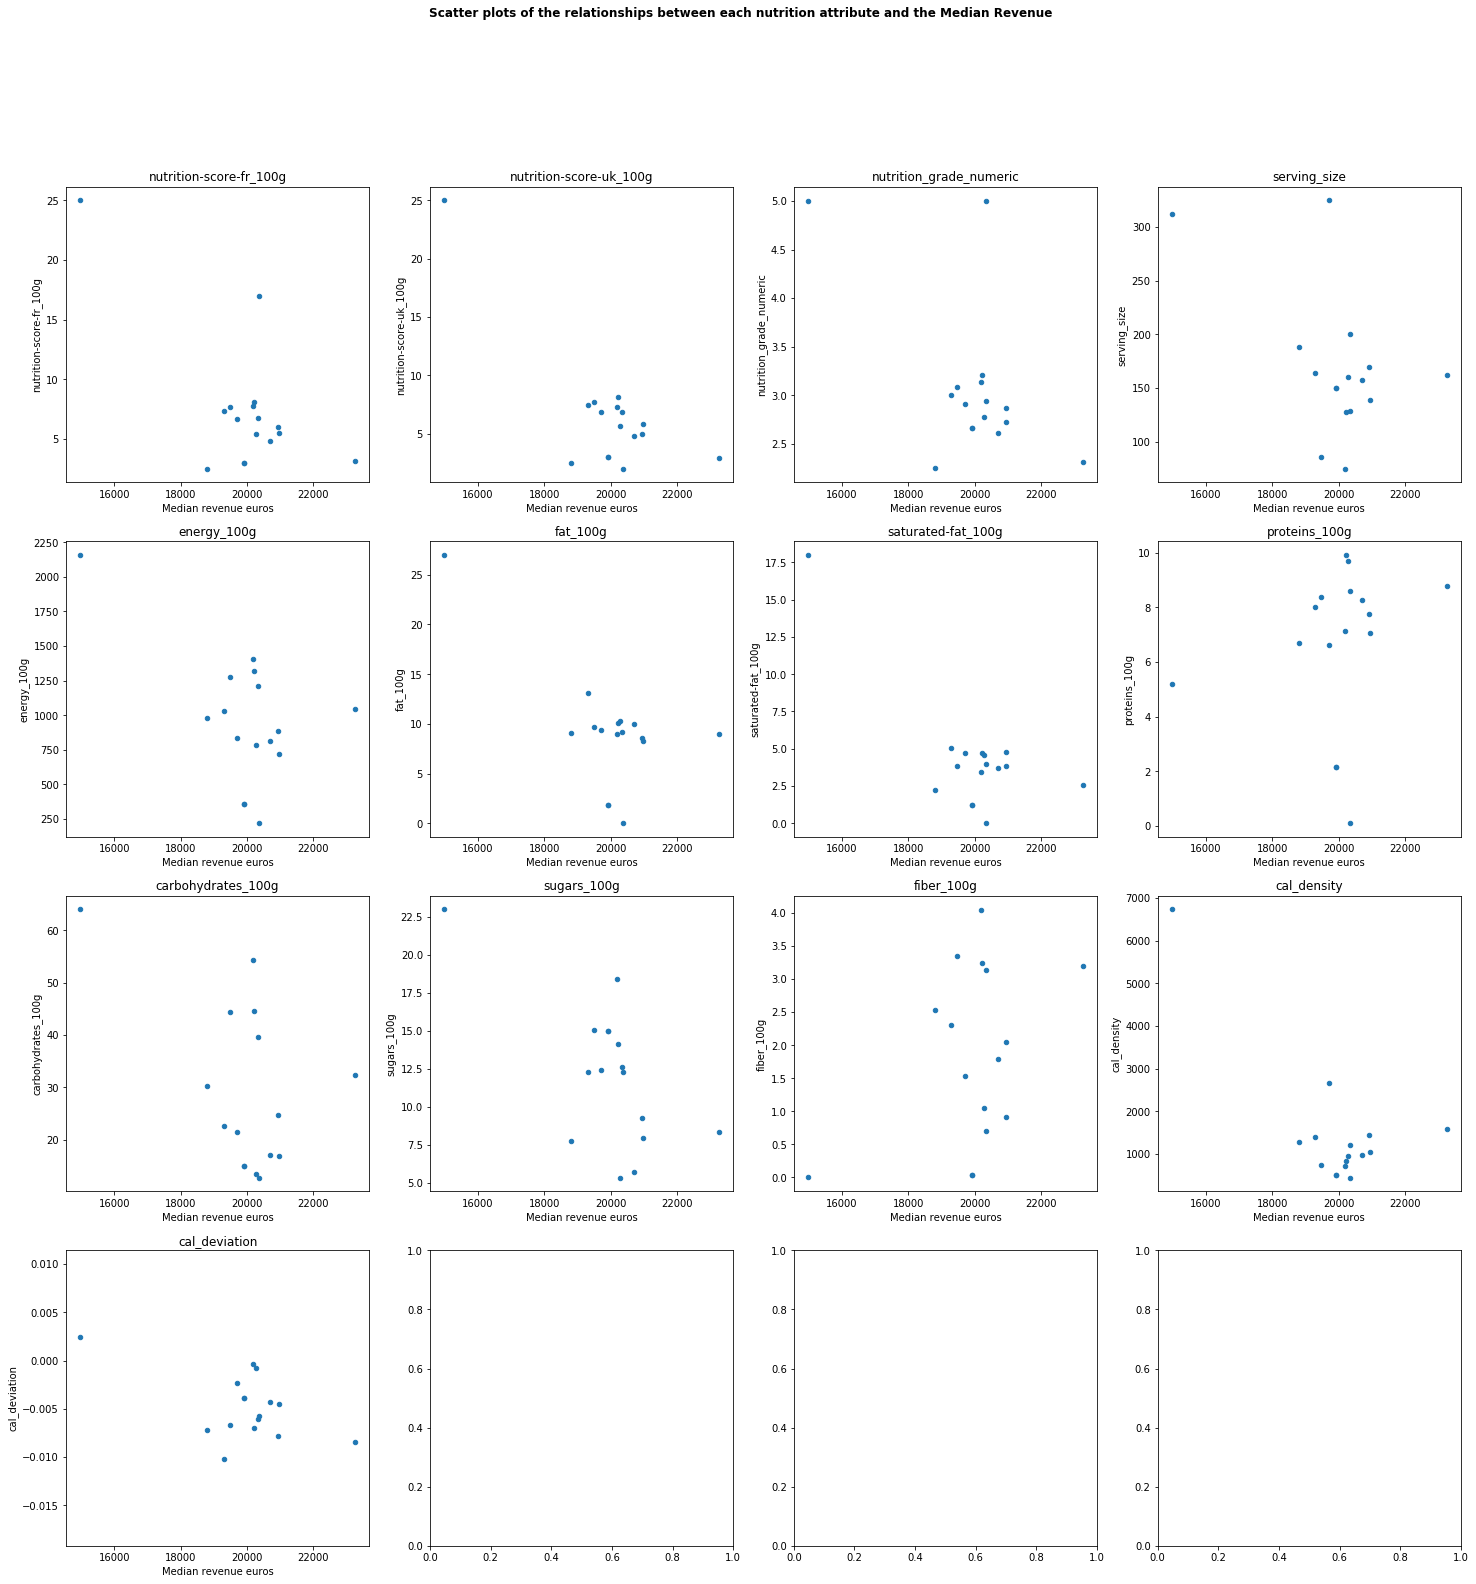

In [61]:
plot_scatter(dataframe_reg)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


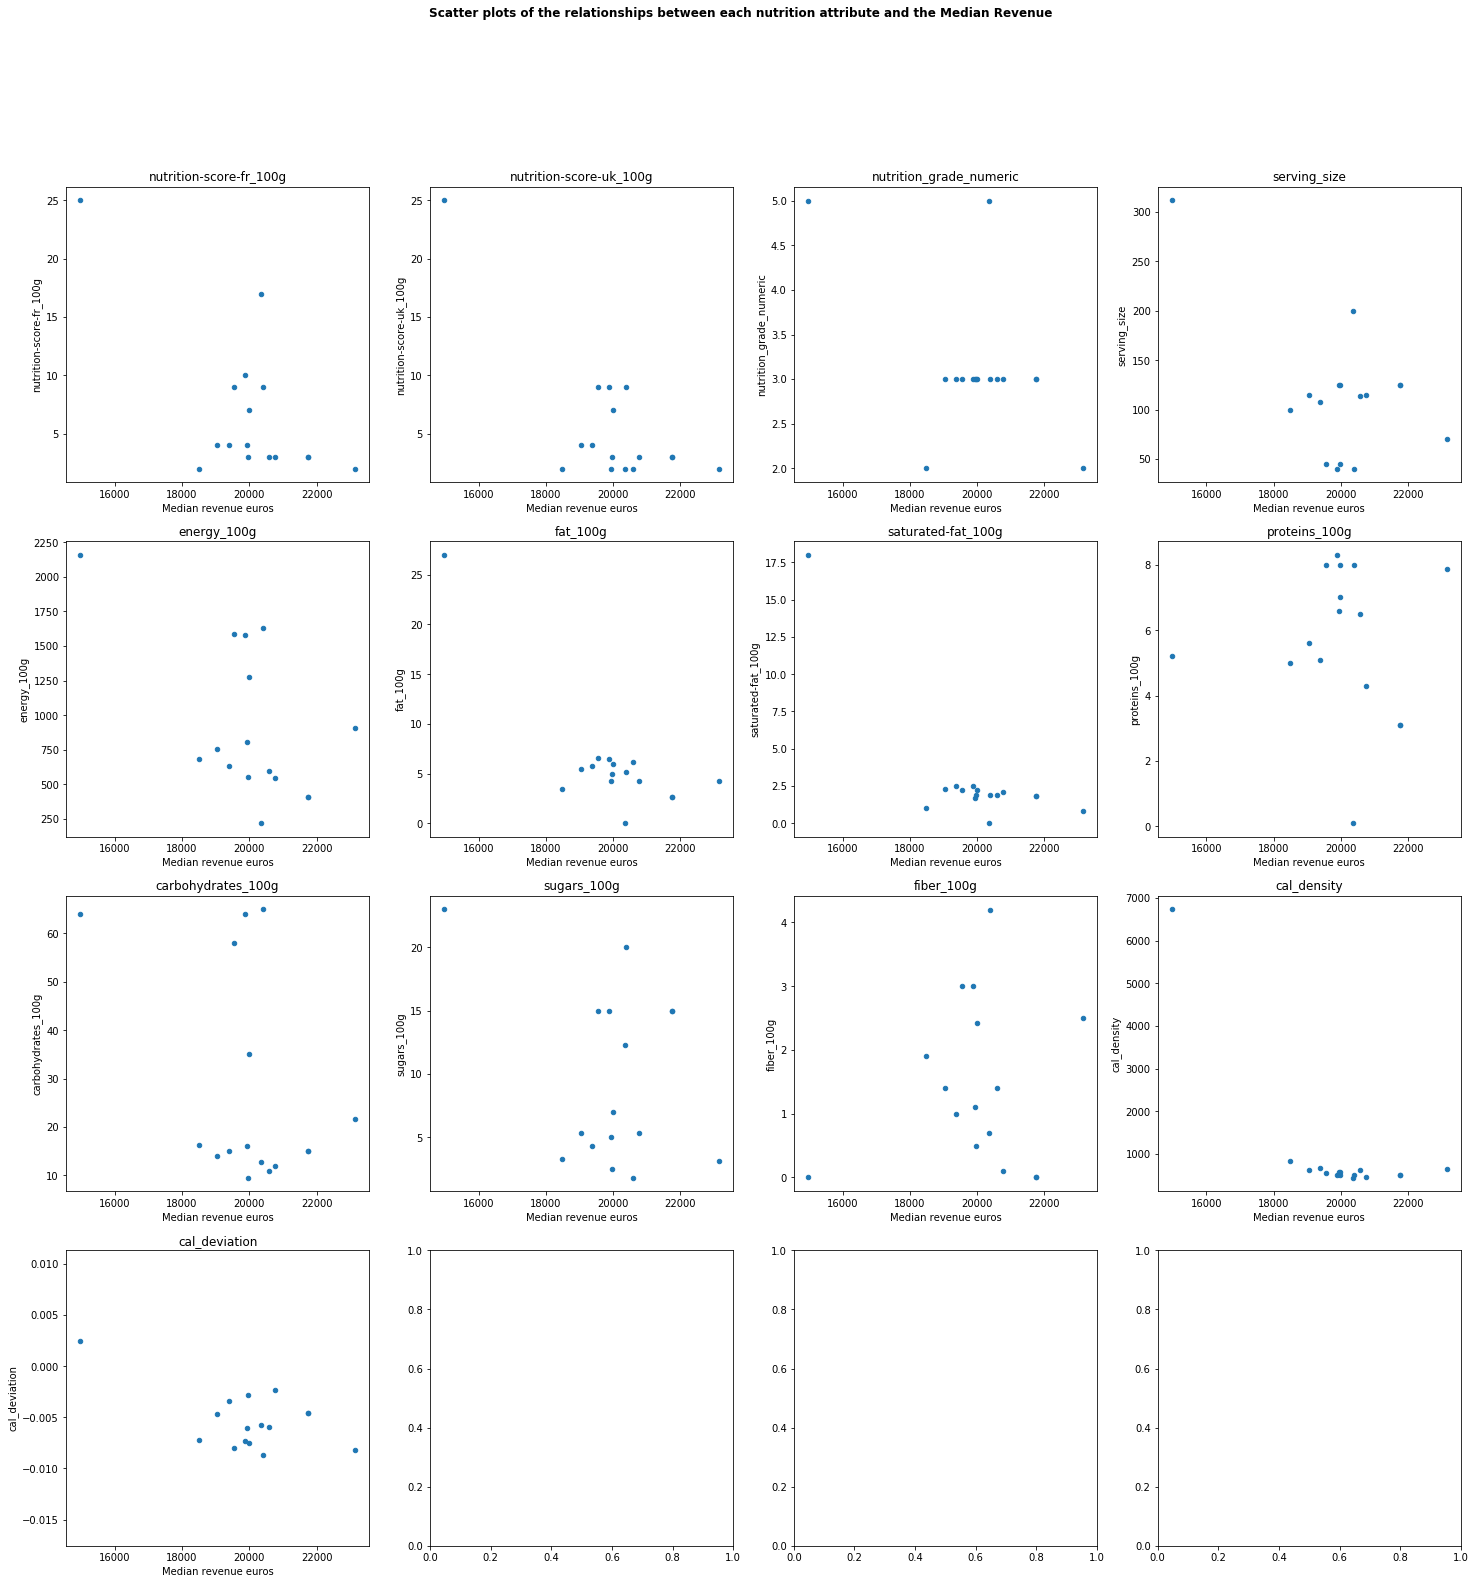

In [62]:
plot_scatter(dataframe_reg_med)

In [63]:
def cluster(df, eps, min_samples):
    X = StandardScaler().fit_transform(df)

    # Compute DBSCAN
    db = DBSCAN(eps=0.3, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))

    # Plot result
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    return labels

In [421]:
def cluster(df, eps, min_samples):
    # Normalize
    X = StandardScaler().fit_transform(df)

    # DBSCAN
    db = DBSCAN(eps, min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    silhouette_coeff = metrics.silhouette_score(X, labels)
    
    return silhouette_coeff, n_clusters_, n_noise_, labels

Estimated number of clusters: 1
Estimated number of noise points: 116
Silhouette Coefficient: 0.371


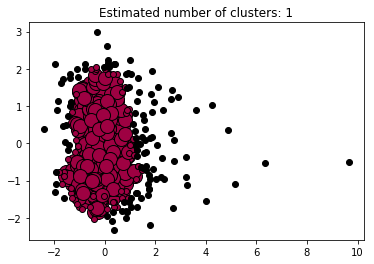

In [69]:
labels = cluster(dataframe_city[['Median revenue euros', 'nutrition-score-fr_100g']], 0.3, 1)

Estimated number of clusters: 2
Estimated number of noise points: 80
Silhouette Coefficient: 0.148


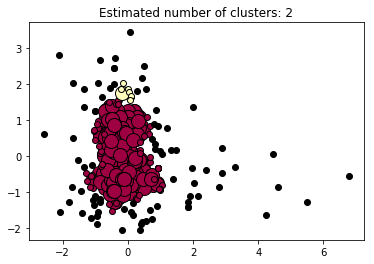

In [75]:
labels = cluster(dataframe_arr[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 10)

Estimated number of clusters: 2
Estimated number of noise points: 87
Silhouette Coefficient: 0.019


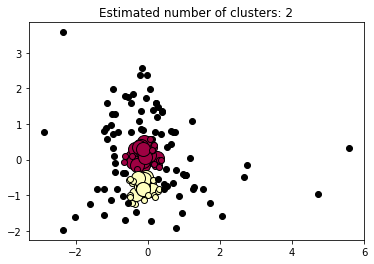

In [97]:
labels = cluster(dataframe_dep[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 2)

In [93]:
labels = cluster(dataframe_reg[['Median revenue euros', 'energy_100g']], 100, 1)

Estimated number of clusters: 0
Estimated number of noise points: 16


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

# 6. Correlation analysis 

In [199]:
def plot_corr_matrix(df1, df2, geography):
    corr1 = df1.corr()
    corr2 = df2.corr()
    names1 = list(corr1.columns)
    names2 = list(corr1.columns)
    # plot correlation matrix
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5.5))
    f.suptitle("Correlation matrix for " + geography, y=1.3, fontweight="bold")
    
    cax1 = ax1.matshow(corr1, vmin=-1, vmax=1)
    ticks1 = np.arange(0, len(names1), 1)
    ax1.set_xticks(ticks1)
    ax1.set_yticks(ticks1)
    ax1.set_xticklabels(names1)
    ax1.set_yticklabels(names1)
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_title('Mean', y=1.45)
    
    cax2 = ax2.matshow(corr2, vmin=-1, vmax=1)
    ticks2 = np.arange(0, len(names2), 1)
    ax2.set_xticks(ticks2)
    ax2.set_yticks(ticks2)
    ax2.set_xticklabels(names2)
    ax2.set_yticklabels(names2)
    ax2.tick_params(axis='x', labelrotation=90)
    ax2.set_title('Median', y=1.45)
    
    f.colorbar(cax1)
    plt.show()

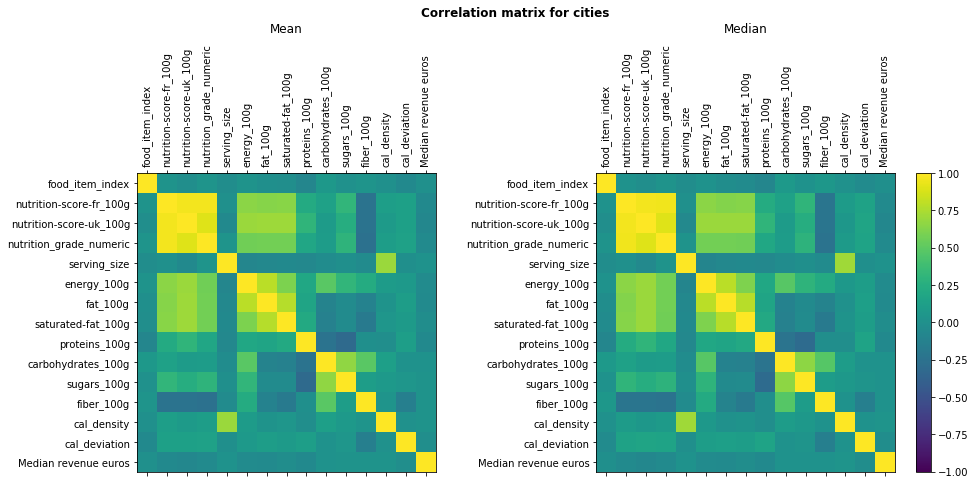

In [200]:
plot_corr_matrix(dataframe_city, dataframe_city_med, "cities")

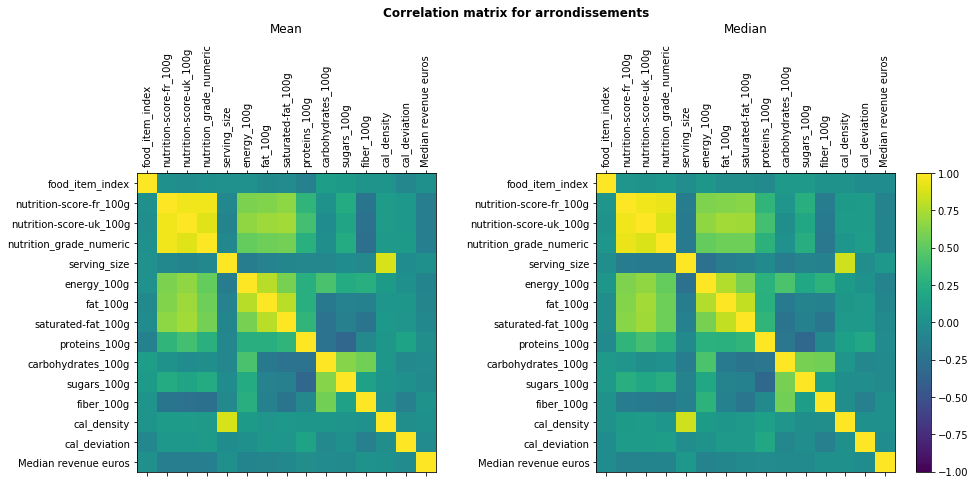

In [202]:
plot_corr_matrix(dataframe_arr, dataframe_arr_med, "arrondissements")

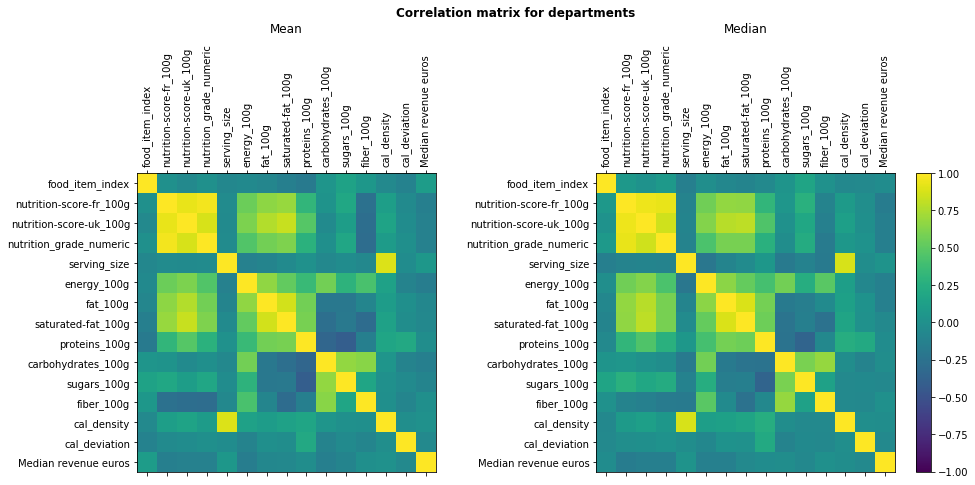

In [203]:
plot_corr_matrix(dataframe_dep, dataframe_dep_med, "departments")

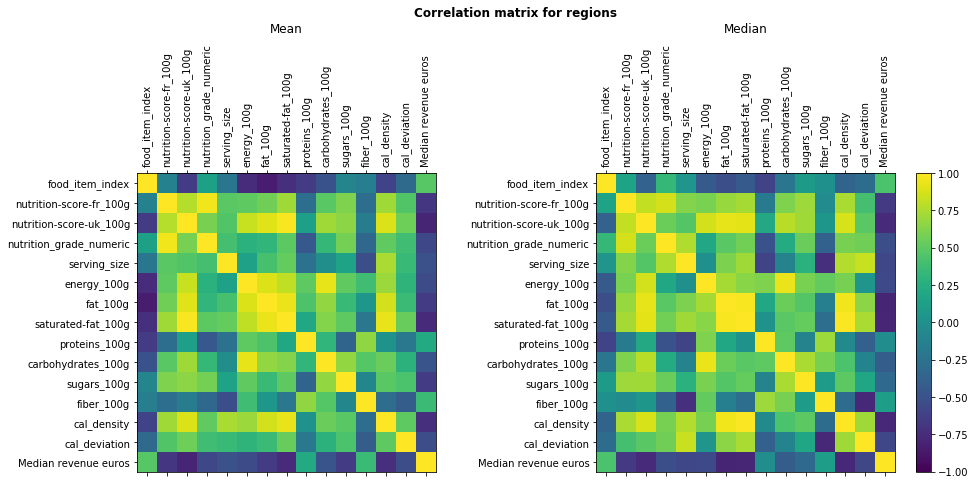

In [204]:
plot_corr_matrix(dataframe_reg, dataframe_reg_med, "regions")

Hooray, we found something at the region level! Let's see more closely how significant it is:

In [215]:
from scipy import stats

In [267]:
def pearson_pval_df(df):
    for col in df.columns:
        if col != 'Median revenue euros' and col != 'food_item_index' and col != 'Region':
            r, p = stats.pearsonr(df[col], df['Median revenue euros'])
            print('{:<30}{:<16}{:<28.3f}{:<10}{:<30.3f}'.format(col, 'Pearson coeff', r, 'p-value', p))

In [268]:
pearson_pval_df(dataframe_reg)

nutrition-score-fr_100g       Pearson coeff   -0.683                      p-value   0.004                         
nutrition-score-uk_100g       Pearson coeff   -0.794                      p-value   0.000                         
nutrition_grade_numeric       Pearson coeff   -0.570                      p-value   0.021                         
serving_size                  Pearson coeff   -0.501                      p-value   0.048                         
energy_100g                   Pearson coeff   -0.540                      p-value   0.031                         
fat_100g                      Pearson coeff   -0.650                      p-value   0.006                         
saturated-fat_100g            Pearson coeff   -0.754                      p-value   0.001                         
proteins_100g                 Pearson coeff   0.222                       p-value   0.409                         
carbohydrates_100g            Pearson coeff   -0.477                      p-valu

In [269]:
pearson_pval_df(dataframe_reg_med)

nutrition-score-fr_100g       Pearson coeff   -0.662                      p-value   0.005                         
nutrition-score-uk_100g       Pearson coeff   -0.753                      p-value   0.001                         
nutrition_grade_numeric       Pearson coeff   -0.517                      p-value   0.040                         
serving_size                  Pearson coeff   -0.573                      p-value   0.020                         
energy_100g                   Pearson coeff   -0.558                      p-value   0.025                         
fat_100g                      Pearson coeff   -0.790                      p-value   0.000                         
saturated-fat_100g            Pearson coeff   -0.783                      p-value   0.000                         
proteins_100g                 Pearson coeff   -0.023                      p-value   0.931                         
carbohydrates_100g            Pearson coeff   -0.414                      p-valu

From the mean dataframe, the columns for which the correlation with the Median revenue is significant (i.e. the corresponding p-value is below 0.05) are:

* nutrition-score-fr_100g          
* nutrition-score-uk_100g  
* nutrition_grade_numeric  
* serving_size             
* energy_100g              
* fat_100g                 
* saturated-fat_100g   
* sugars_100g
* cal_density       
* cal_deviation     

For all these columns, we have a negative correlation between each of them and the mean median revenue for the overall region. The Pearson coefficients are all below the -0.3 threshold that allows us to claim that there is a correlation. 
The Pearson coefficients are actually below -0.5 for each of these columns.

The negative correlation is more significant for sugars, fat, saturated fat, the nutrition scores and the calory density (coefficient around **-0.7 / -0.8**).

For the median dataframe, we can observe the same tendencies. 

# 7. Vizzzzzzzzz

We only found an actual relationship for regions so this is what we're gonna viz.

First we have to reset the indexes.

In [205]:
dataframe_reg.reset_index(inplace=True)
dataframe_reg_med.reset_index(inplace=True)

Then we have to transform the 'Region' column from int to string and add a 0 if the region number only has one character.

In [206]:
dataframe_reg['Region'] = dataframe_reg['Region'].apply(lambda x : str(x))
dataframe_reg['Region'] = dataframe_reg['Region'].apply(lambda x : '0'+x if len(x) == 1 else x)

dataframe_reg_med['Region'] = dataframe_reg['Region'].apply(lambda x : str(x))
dataframe_reg_med['Region'] = dataframe_reg['Region'].apply(lambda x : '0'+x if len(x) == 1 else x)

Region borders

In [208]:
# geojson: https://github.com/gregoiredavid/france-geojson
reg_borders = json.load(open("../data/processed/regions-avec-outre-mer.geojson"))

And now the viz:

In [209]:
for column in ['nutrition_grade_numeric', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']:
    map_nutrition = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
    scale = np.linspace(np.min(dataframe_reg[column]), np.max(dataframe_reg[column]), 6)
    map_nutrition.choropleth(geo_data=reg_borders, 
                           data=dataframe_reg, 
                           columns=['Region', column],
                           key_on='feature.properties.code',
                           legend_name=column,
                           threshold_scale=list(scale),
                           fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                      )

    map_nutrition.save("../data/processed/map_{}.html".format(column))
    display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format(column)))

In [210]:
map_revenue = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
scale = np.linspace(np.min(dataframe_reg['Median revenue euros']), np.max(dataframe_reg['Median revenue euros']), 6)
map_revenue.choropleth(geo_data=reg_borders, 
                       data=dataframe_reg, 
                       columns=['Region', 'Median revenue euros'],
                       key_on='feature.properties.code',
                       legend_name='Median revenue euros',
                       threshold_scale=list(scale),
                       fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                  )

map_revenue.save("../data/processed/map_{}.html".format('Median revenue euros'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('Median revenue euros')))